## Create Initial states

In [1]:
import numpy as np
from pathlib import Path
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.models.normal_deg import NormalDegradationModel as NModel

In [2]:
data_name = "DS03"

device = "cuda" if torch.cuda.is_available() else "cpu"
experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'
os.makedirs(states_dir, exist_ok=True)

## Import training data


In [3]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')

### get only degraded data

In [4]:
hi_df = hi_df[hi_df['hs']==0]
del hi_df['hs']

In [5]:
perform_alias = [col for col in hi_df.columns if col not in ['unit','cycle']]
units = hi_df['unit'].unique().tolist()

In [6]:
performs_train = {alias: 
    {int(unit): hi_df[hi_df['unit']==unit][alias].values for unit in units} 
    for alias in perform_alias
}
time_train = {int(unit): hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Load best model

In [12]:
t = np.linspace(0.1, 100, 400)  # Start from 0.1 instead of 0.0 (LogNormal support is t > 0)
s = np.linspace(0.0, 1.0, 300)

norm_models = []
s_data = []
t_data = []
for name, units_perform in performs_train.items():
	if name != 'T48':
		continue
	for unit, perform in units_perform.items():
		print(f"  Unit: {unit}") 

		s_data.append(perform)
		t_data.append(time_train[unit])

		best_model = NModel()
		best_model.load_state_dict(
			torch.load(states_dir /name/f'unit_{unit}'/ "best_model.pt", map_location=device)
		)
		best_model.to(device)
		best_model.eval()
  
		norm_models.append(best_model)
t_data = np.concatenate(t_data)
s_data = np.concatenate(s_data)

  Unit: 1
  Unit: 2
  Unit: 3
  Unit: 4
  Unit: 5
  Unit: 6
  Unit: 7
  Unit: 8
  Unit: 9


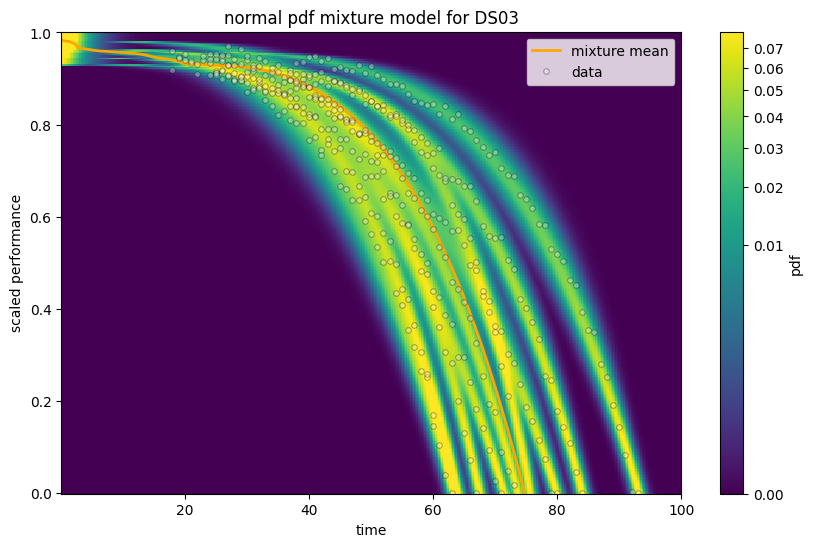

In [16]:
from src.models.mm import MixtureDEGModel
weights = torch.ones(len(norm_models),device=device) / len(norm_models)
mix = MixtureDEGModel(norm_models, weights)
ax=mix.plot_distribution(t, s, 
                    func="pdf",
					title=f"normal pdf mixture model for {data_name}",
		)
ax.set_xlim([t.min(), t.max()])
ax.plot(t_data,s_data,'o',
		color='white',alpha=0.3,markersize=4,markeredgecolor='black',markeredgewidth=0.8,
		label='data')
ax.legend()
plt.show()